# Coprporate Bonds

The goal of the project is to determine the credit curve from corporate bonds emitted by three differently rated companies. The input parameters are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotation);
* the average three-year corporate transition matrix (1981-2021);
* a pool of bonds data (nominal, start date, end date...).

Once the three credit curves have been determined compare them with the transition matrix and comment the results.

Finally determine the yield to maturity of each bond.

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for evaluation of risky flows.

Remember to reuse the code we developed during the lessons in `finmarkets.py` or presented in the notes, as much as possible !

When it is not possible write your own classes.

[OIS quotes](https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/ois_quotes.xlsx)

[Transition Matrix](https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/transition_matrix.csv)

[Corporate Bonds](https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/bonds.csv)

In [ ]:
from datetime import date

pricing_date = date(2022, 11, 26)
bond_tenor = 6

In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [27]:
import pandas as pd

data = {}
index = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C']
data['AAA'] = [87.09, 0.48, 0.02, 0, 0.01, 0, 0]
data['AA'] = [9.05, 87.32, 1.56, 0.08, 0.02, 0.02, 0]
data['A'] = [0.53, 7.72, 88.73, 3.19, 0.1, 0.06, 0.09]
data['BBB'] = [0.05, 0.46, 4.97, 86.72, 4.52, 0.15, 0.16]
data['BB'] = [0.11, 0.05, 0.25, 3.48, 78.12, 4.54, 0.49]
data['B'] = [0.03, 0.06, 0.11, 0.42, 6.66, 74.73, 13.42]
data['CCC/C'] = [0.05, 0.02, 0.01, 0.09, 0.53, 4.81, 43.91]
data['D'] = [0, 0.02, 0.05, 0.15, 0.6, 3.18, 26.55]
data['NR'] = [3.1, 3.88, 4.29, 5.86, 9.43, 12.51, 15.39]

df = pd.DataFrame(data, index=index)
print (df.head())

       AAA     AA      A    BBB     BB     B  CCC/C     D    NR
AAA  87.09   9.05   0.53   0.05   0.11  0.03   0.05  0.00  3.10
AA    0.48  87.32   7.72   0.46   0.05  0.06   0.02  0.02  3.88
A     0.02   1.56  88.73   4.97   0.25  0.11   0.01  0.05  4.29
BBB   0.00   0.08   3.19  86.72   3.48  0.42   0.09  0.15  5.86
BB    0.01   0.02   0.10   4.52  78.12  6.66   0.53  0.60  9.43


In [76]:
import pandas as pd
from datetime import date

ois_quotes = pd.read_excel("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/ois_quotes.xlsx")
print (ois_quotes.head())

   months   quotes
0       1  0.70575
1       2  1.03170
2       3  1.23200
3       4  1.42975
4       5  1.59400


The first step is to determine the discoutn curve using the bootstrap method.
So define a set of OIS according to the market quotes given in inputs.

In [77]:
from finmarkets import OvernightIndexSwap

ois_pillar_dates = [pricing_date]

swaps = []
for q in range(len(ois_quotes)):
    swap = OvernightIndexSwap(1, pricing_date,
                              ois_quotes.loc[q, 'quotes']*0.01,
                              ois_quotes.loc[q, 'months'])
    
    swaps.append(swap)
    ois_pillar_dates.append(swap.payment_dates[-1])

n_df_vector = len(ois_pillar_dates)

Then define the objective function with a discount curve with unknown discount factors $\vec{x}$ and the squared sum of the swap NPVs to minimize.

In [78]:
import numpy as np
from finmarkets import DiscountCurve

def objective_function(x):
    x = np.insert(x, 0, 1)
    curve = DiscountCurve(ois_pillar_dates, x)    
    sum_sq = 0.0 
    
    for swap in swaps: 
        sum_sq += swap.npv(curve)**2
        
    return sum_sq

Set initial values and boundaries of the unknown factors (remember that the first factor has to be 1 since refers to today's discount).

In [79]:
from scipy.optimize import minimize 

x0 = [1.0 for i in range(len(swaps))]
bounds = [(0.01,100.0) for i in range(len(swaps))]

result = minimize(objective_function, x0, bounds = bounds)

Check the results to be sure the minimization worked...

In [80]:
print (result)

      fun: 4.478741359082851e-11
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.41080023e-08,  1.11630083e-07,  1.62044515e-07,  1.83820447e-07,
        1.68117701e-07,  1.14205414e-07,  2.52596409e-08, -8.48856870e-08,
       -2.02032288e-07, -3.13249797e-07, -3.98753269e-07, -5.06344361e-06,
        7.66996898e-06,  2.99293561e-06,  2.85475205e-06,  2.55849549e-06,
        2.23420140e-06,  1.78106999e-06,  1.35173295e-06,  9.07612475e-07,
        4.73290406e-07,  3.85937091e-08, -3.10166157e-07, -2.43397690e-06,
       -1.27213820e-06, -4.13545275e-06, -4.22991323e-06, -1.50202959e-06,
        5.07716363e-06, -1.06181575e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 217
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([0.99941224, 0.99825494, 0.99686151, 0.99525686, 0.99335854,
       0.99136712, 0.98920021, 0.98696954, 0.98469204, 0.98233424,
       0.98001257, 0.97763314, 0.96381811, 0.9504473 ,

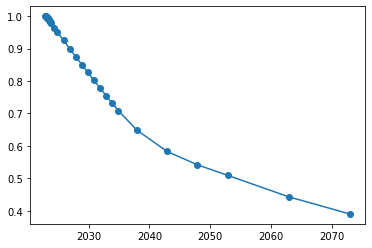

In [81]:
from matplotlib import pyplot as plt

dfs = np.insert(result.x, 0, 1)
plt.plot(ois_pillar_dates, dfs, marker='o')
plt.show()

In [34]:
print ("Initial value of obj_func {}".format(objective_function(x0)))
print ("Final value of obj_func {}".format(objective_function(result.x)))

Initial value of obj_func 3.792835716150977
Final value of obj_func 4.464095569321427e-11


Finally create the discount curve to be used in the exercise.

In [82]:
dc_curve = DiscountCurve(ois_pillar_dates, dfs)
dc_curve.df(date(2030,10,31))

0.8040472332190379

In [147]:
import pandas as pd
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta

labels = ['JNJ', 'NFLX', 'PTRB']
df = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/bonds2.csv")
bonds_df = []
for l in labels:
  bonds_df.append(df[df['code'].str.startswith(l)])


In [148]:
from finmarkets import generate_dates

class BondPricer:     
  def __init__(self, nominal, start_date, maturity, coupon, tenor_months, current_price):
    self.nominal = nominal
    self.maturity = maturity
    self.payment_dates = generate_dates(start_date, maturity, tenor_months)
    self.tenor = tenor_months / 12
    self.coupon = coupon
    self.cur_price = current_price

  def price(self, pricing_date, discounting_curve, credit_curve, recovery=0.4):
    val_nodef = 0
    for i in range(1, len(self.payment_dates)):
      if self.payment_dates[i] > pricing_date:
        val_nodef += discounting_curve.df(self.payment_dates[i]) * self.coupon * self.tenor * \
                    credit_curve.ndp(self.payment_dates[i])
    val_nodef += discounting_curve.df(self.payment_dates[-1])*credit_curve.ndp(self.payment_dates[-1])
    
    val_def = 0
    d = pricing_date
    while d <= self.payment_dates[-1]:
      val_def += recovery * discounting_curve.df(d) * (credit_curve.ndp(d)-
                                                       credit_curve.ndp(d+relativedelta(days=1)))
      d += relativedelta(days=1)
    return self.nominal * (val_nodef + val_def)
        
  def npv(self, pricing_date, discounting_curve, credit_curve, recovery=0.4):
    return self.price(pricing_date, discounting_curve, credit_curve, recovery) - self.cur_price

In [149]:
import numpy as np
from finmarkets import CreditCurve

def objective_function(x, pricing_date, pillar_dates, bonds, dc):
    x = np.insert(x, 0, 1)
    curve = CreditCurve(pillar_dates, x)    
    sum_sq = 0.0 
    
    for b in bonds: 
        sum_sq += b.npv(pricing_date, dc, curve)**2
        
    return sum_sq

In [156]:
bonds = {}
results = {}
credit_curves = {}
tenor = 6

for j, l in enumerate(labels):
  bonds[l] = []
  pillar_dates = [pricing_date]
  for i in range(len(bonds_df[j])):
    maturity = datetime.datetime.strptime(bonds_df[j].iloc[i]['maturity'], '%Y-%m-%d').date()
    start_date = datetime.datetime.strptime(bonds_df[j].iloc[i]['last_cpn'], '%Y-%m-%d').date()
    maturity_months = (maturity - start_date).days//30
    bonds[l].append(BondPricer(100, start_date, maturity_months, 
                            bonds_df[j].iloc[i]['coupon']*0.01, bond_tenor, bonds_df[j].iloc[i]['price']))
    pillar_dates.append(bonds[l][-1].payment_dates[-1])

  x0 = [.5 for i in range(len(bonds[l]))]
  bounds = [(0.01, 1.0) for i in range(len(bonds[l]))]

  results[l] = minimize(objective_function, x0, bounds = bounds,
                  args=(pricing_date, pillar_dates, bonds[l], dc_curve))

  ndps = np.insert(results[l].x, 0, 1)
  credit_curves[l] = CreditCurve(pillar_dates, ndps)

In [157]:
print (results['NFLX'])

      fun: 3.323735253987743e-13
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.98797035e-06,  1.03230715e-05, -8.37366869e-06,  3.85179254e-07,
        1.34706717e-06,  2.18988632e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 70
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([0.91773648, 0.86934486, 0.83969493, 0.72955169, 0.66316073,
       0.64168625])


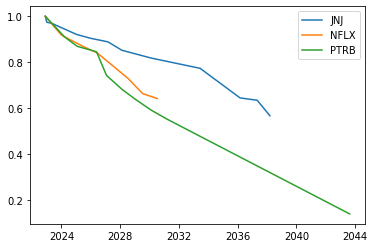

In [159]:
import matplotlib.pyplot as plt

for l in labels:
  plt.plot(credit_curves[l].pillar_dates, credit_curves[l].pillar_ndps, label=l)
plt.legend()
plt.show()

In [189]:
print (1-credit_curves['JNJ'].ndp(pricing_date+relativedelta(years=1)))
print (1-credit_curves['NFLX'].ndp(pricing_date+relativedelta(years=1)))
print (1-credit_curves['PTRB'].ndp(pricing_date+relativedelta(years=1)))

0.04714631075350184
0.07480469335745232
0.06944318849725661


In [185]:
from scipy.optimize import bisect

def yieldtom(y, pricing_date, b, recovery=0.4):
    val = 0
    for i in range(1, len(b.payment_dates)):
      deltat = (b.payment_dates[i]-pricing_date).days/365
      if b.payment_dates[i-1] <= pricing_date <= b.payment_dates[i]:
        val += np.exp(-y*deltat) * b.coupon * (b.payment_dates[i]-b.payment_dates[i-1]).days/365 *  \
               (b.payment_dates[i]-pricing_date)/((b.payment_dates[i]-b.payment_dates[i-1]))
      else:
        val += np.exp(-y*deltat) * b.coupon * (b.payment_dates[i]-b.payment_dates[i-1]).days/365
    val += np.exp(-y*deltat)
    return b.nominal * val - b.cur_price

for i in range(len(bonds['NFLX'])):
  b = bonds['NFLX'][i]
  print (bisect(yieldtom, 0, 1, args=(pricing_date, b,)))


0.04896276209001371
0.05146665739994205
0.04971229417606082
0.052524455762977595
0.056156582048060955
0.05565226271755819


In [161]:
import random

students = ['Kideyis Erman', 'Camilla Corsini', 'Federico Ruggieri', 'Simone Allia - Andrea Fanani',
            'Yuri Passarini', 'Erica Romano', 'Gianmarco Ottaviano', 'Giorgio Tumeo']
projects = ['Basis-Swap', 'Fixed Coupon Bonds', 'Credit VaR', 'CVA',
            'Portfolio', 'Model Calibration', 'Cross Currency Swap',
            'Copula']

seed = 20221126180446
random.seed(seed)
idx_std = random.sample(range(len(students)), len(students))

for i in range(len(students)):
  print (projects[idx_std[i]], students[i])

Cross Currency Swap Kideyis Erman
Portfolio Camilla Corsini
Copula Federico Ruggieri
Basis-Swap Simone Allia - Andrea Fanani
Fixed Coupon Bonds Yuri Passarini
CVA Erica Romano
Model Calibration Gianmarco Ottaviano
Credit VaR Giorgio Tumeo
